## Glob paths to my DEMs.

In [ ]:
import glob
from concurrent.futures import ThreadPoolExecutor
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
path_list = glob.glob('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/watersheds/*')
csv_list = glob.glob('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/csvs/*')

In [ ]:
"""
Makes CSVS, PNGS, and TIFFs for each watershed in the path_list.
"""
# i=0
# for path in path_list:
#     !python /sciclone/home/ntlewis/Nick-Lewis-Research/working_files/py_scripts/relief.py x x x x watersheds/{path} pngs/output_{i}.png csvs/relief_{i}.csv
#     i+=1

In [ ]:
"""
Reads VA and WV geology shapefiles, combines them, and sets the CRS.
"""

geol_va = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/geology/VA/VA_geol_poly.shp')
geol_wv = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/geology/WV/WV_geol_poly.shp')
geol = pd.concat([geol_va, geol_wv])
geol = gpd.GeoDataFrame(geol, geometry=geol.geometry)
display(geol)
goal_crs = geol.crs

In [ ]:
"""
Reads VA and WV physiographic regions shapefiles, combines them.
"""

va_regions = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/regions/VA/Virginia_Physiographic_Regions.shp').to_crs(goal_crs)
wv_regions = gpd.read_file('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/peripherals/regions/wv_physio_FeaturesToJSON.geojson').to_crs(goal_crs)
regions = pd.concat([va_regions, wv_regions])
regions = gpd.GeoDataFrame(regions, geometry=regions.geometry)

In [ ]:
"""
Reads a CSV file and converts it to a GeoDataFrame.
"""
def make_df(path):
    gdf = gpd.GeoDataFrame(data = pd.read_csv(path, index_col = 0))
    gdf.set_geometry(gpd.points_from_xy(gdf.East, gdf.North), inplace=True)
    gdf = gdf.set_crs(goal_crs)
    gdf = gdf.drop(columns=['y', 'max_y', 'x', 'max_x', 'rank'])
    return gdf

In [ ]:
with ThreadPoolExecutor() as executor:
    results_iter = executor.map(make_df, csv_list)
    results = list(results_iter)

relief = pd.Series()
avg_elev = pd.Series()
for res in results:
    relief = pd.concat([relief, res.Relief], ignore_index=True)
    avg_elev = pd.concat([avg_elev, res.avg_elevation], ignore_index=True)

In [ ]:
"""
Algorith for determining relict points.
"""

i=0
for res in results:
    min_el = avg_elev.quantile(0.85)
    max_r = relief.quantile(0.15)
    res['relict'] = [True if res.Relief.iloc[i] <= max_r and res.avg_elevation.iloc[i] >= max_r else False for i in range(len(res))]
    res['basin'] = i
    i+=1

In [ ]:
def mk_plot(path):
    show(rasterio.open('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/watersheds/'+str(path)), ax=ax)

with ThreadPoolExecutor() as executor:
    fig, ax = plt.subplots(figsize=(20,20), dpi=300)
    ax.set_title('Basins overlaying VA basemap.')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    with rasterio.open('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/get_basins.tiff') as src:
        basemap = show(src, cmap='binary', ax=ax)
        print('Basemap loaded.')
    for res in results:
        sns.scatterplot(data=res[res.relict == True], x='East', y='North', hue='Relief', ax=ax)
        print(f'Relict points plotted for basin {res.basin.iloc[0]}')
    executor.map(mk_plot, path_list)

(-81.5, -80.2)

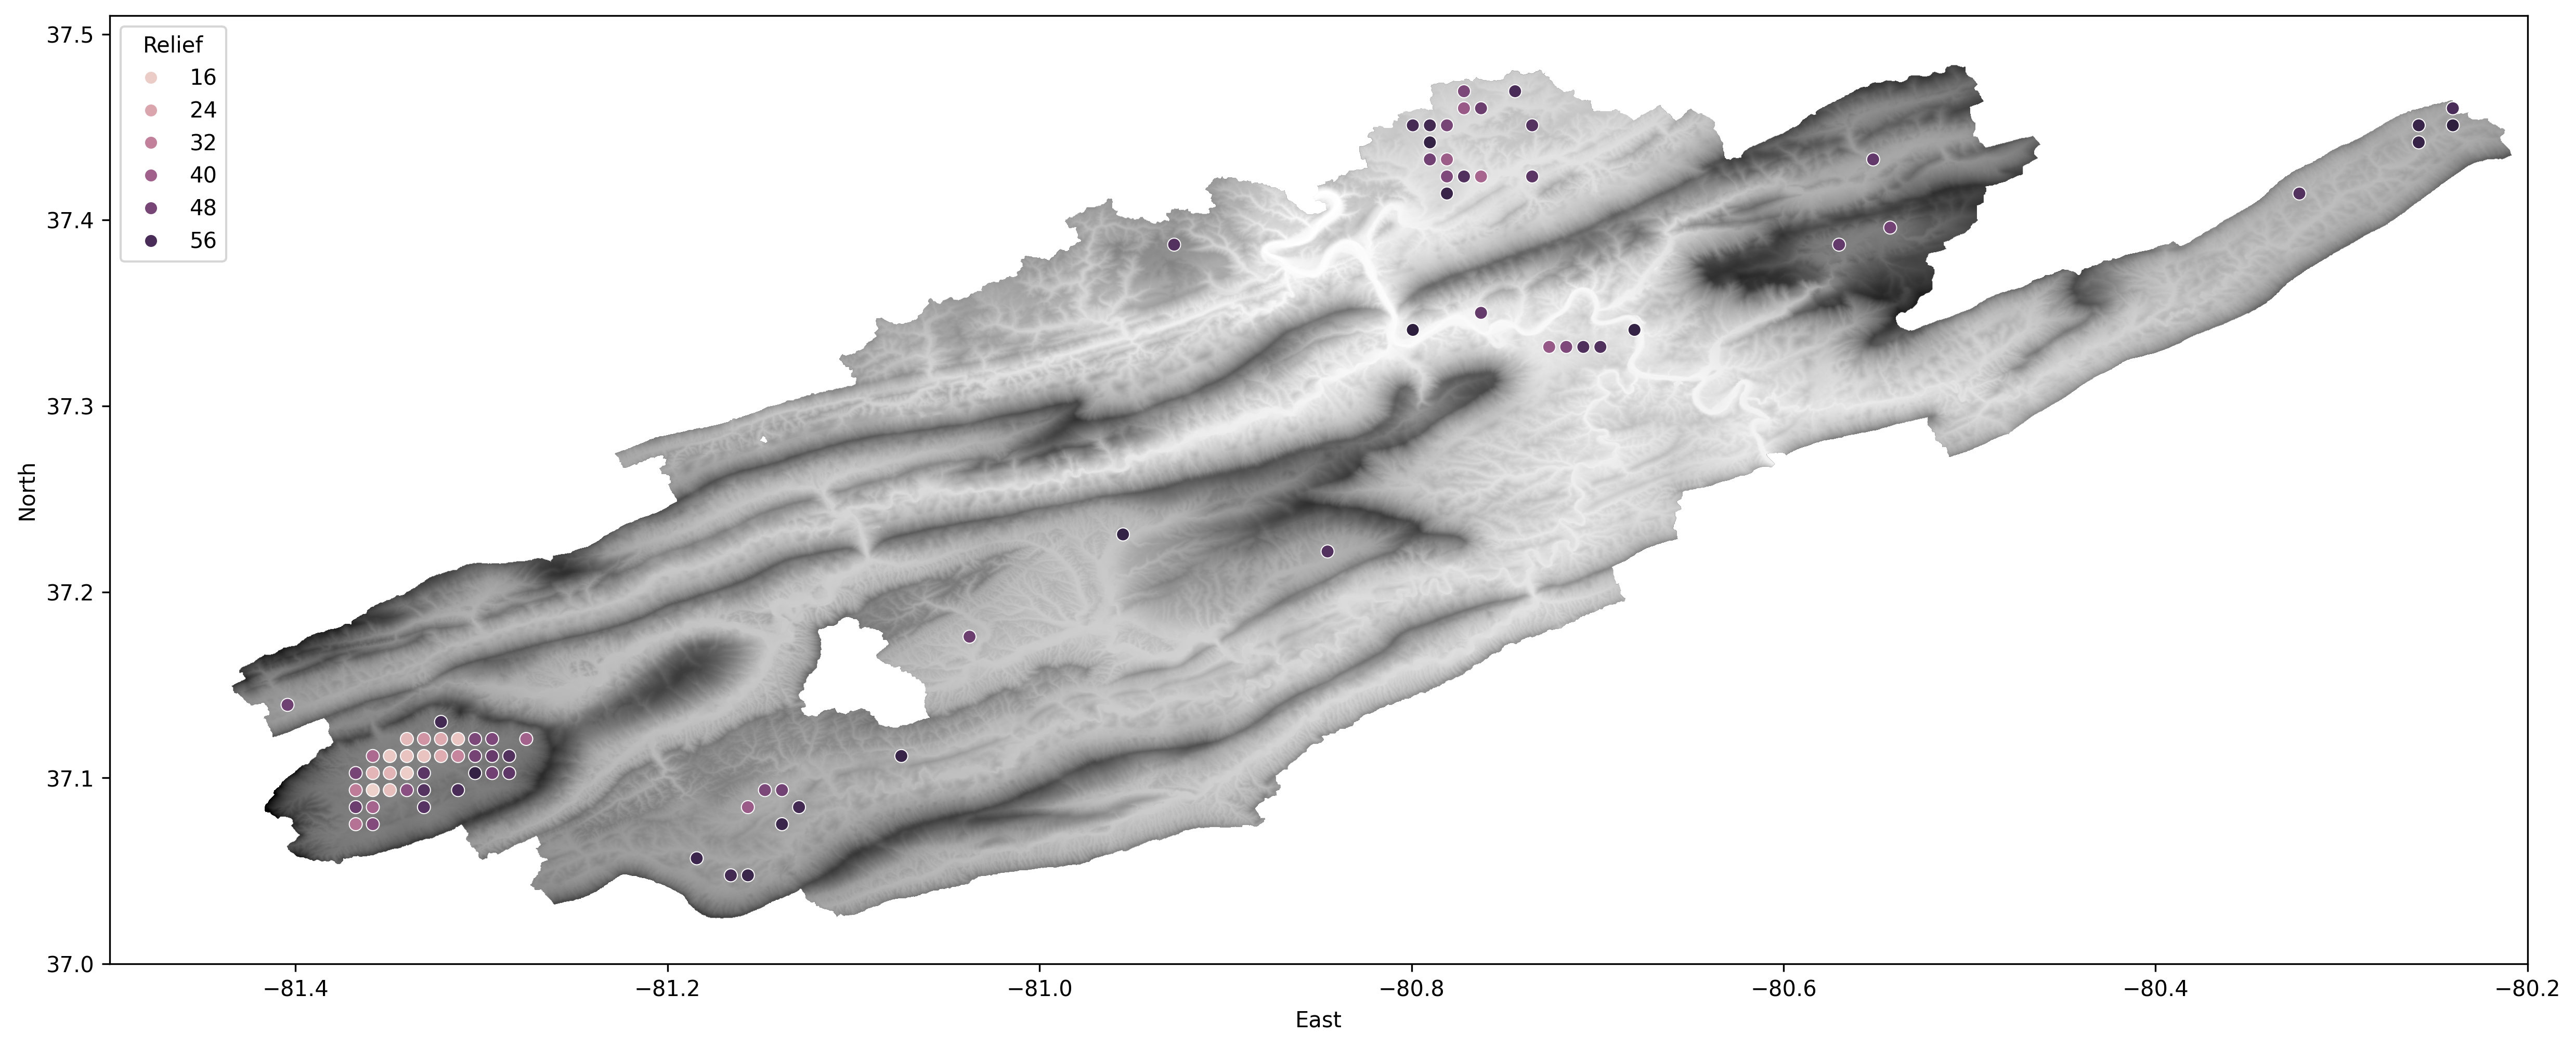

In [30]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
src = rasterio.open('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/watersheds/output_raster_21.tiff')
basemap = show(src, cmap='binary', ax=ax)

def map_relict(df):
    df = df[df['relict']==True]
    sns.scatterplot(data=df, x='East', y='North', hue='Relief', ax=ax)

map_relict(results[21])
ax.set_ylim(bottom=37, top=37.51)
ax.set_xlim(left=-81.5, right=-80.20)

In [ ]:
selected_points = []
for res in results:
    res = gpd.sjoin(res, regions[['PROVINCE', 'geometry']], how='left')
    res.drop(columns=['index_right'], inplace=True)
    selected_points.append(res[res.relict == True][res.PROVINCE.isin(['APPALACHIAN PLATEAUS', 'BLUE RIDGE'])])

In [ ]:
for res in selected_points:
    display(res)

In [ ]:
for res in selected_points:
    display(res)